In [1]:
import argparse
import sys, os
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/stylegan2'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/gan/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/parameters/'))

In [2]:
from typing import List
import numpy as np
import albumentations
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
#from albumentations.torch import ToTensor as ToTensorV2
from torch import Tensor, nn
from torch import optim
from dataset.cardio_dataset import SegmentationDataset
from dataset.lazy_loader import Celeba, W300DatasetLoader
from dataset.lazy_loader import LazyLoader
from dataset.probmeasure import ProbabilityMeasureFabric, ProbabilityMeasure
from dataset.toheatmap import heatmap_to_measure
from loss.losses import Samples_Loss
from modules.hg import HG_softmax2020
from parameters.path import Paths
from dataset.probmeasure import ProbabilityMeasure, ProbabilityMeasureFabric, UniformMeasure2DFactory, \
    UniformMeasure2D01
import copy

In [3]:
from tqdm import tqdm_notebook as tqdm
from modules.linear_ot import SOT, PairwiseDistance, LinearTransformOT

In [4]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.set_device(device)

cuda:3


In [121]:
class SOT2(nn.Module):
    def __init__(self, max_iters: int=100, reg=1e-2):
        super(SOT2, self).__init__()
        self.pdist = PairwiseDistance()
        self.reg = reg
        self.max_iters = max_iters

    def sinkhorn(self, a: Tensor, b: Tensor, M: Tensor):

        device = a.device
        # init data
        dim_a = a.shape[1]
        dim_b = b.shape[1]
        batch_size = a.shape[0]
        assert a.shape[0] == b.shape[0]
        a = a.view(batch_size, dim_a, 1).type(torch.float64)
        b = b.view(batch_size, dim_b, 1).type(torch.float64)

        u = torch.ones((batch_size, dim_a, 1), device=device, dtype=torch.float64) / dim_a
        v = torch.ones((batch_size, dim_b, 1), device=device, dtype=torch.float64) / dim_b

        K = torch.exp(-M.type(torch.float64) / self.reg)
        Kt = K.transpose(1, 2)

        cpt = 0

        P = (u.reshape((batch_size, -1, 1)) * K * v.reshape((batch_size, 1, -1)))

        while cpt < self.max_iters:
            uprev = u
            vprev = v

            KtU = torch.bmm(Kt, u)
            v = b / KtU

            KV = K.bmm(v)
            u = a / KV

            if (torch.any(KtU == 0)
                    or torch.any(torch.isnan(u)) or torch.any(torch.isnan(v))
                    or torch.any(torch.isinf(u)) or torch.any(torch.isinf(v))):
                print('Warning: numerical errors at iteration', cpt)
                u = uprev
                v = vprev
                break

            cpt = cpt + 1

            if cpt % 10 == 0:
                P_new = (u.reshape((batch_size, -1, 1)) * K * v.reshape((batch_size, 1, -1)))
                if (P - P_new).abs().max() < 0.00001:
                    P = P_new
                    break
                else:
                    P = P_new

        return P.type(torch.float32)

    def forward(self, m1: ProbabilityMeasure, m2: ProbabilityMeasure, M: Tensor = None):

        if M is None:
            M = self.pdist(m1.coord, m2.coord)
            M = M / M.max(dim=1)[0].max(dim=1)[0].view(-1, 1, 1)

        a = m1.probability + 1e-8
        a /= a.sum(dim=1, keepdim=True)
        b = m2.probability + 1e-8
        b /= b.sum(dim=1, keepdim=True)
        P = self.sinkhorn(a, b, M)

        return P

In [194]:
def handmadew1(m1,m2):
    lambd = 0.0001
#     with torch.no_grad():
        #A, T = LinearTransformOT.forward(m1, m2, 200)
    m1 = m1.centered()#.multiply(A)
    m2 = m2.centered()
    P = SOT2(300, lambd).forward(m1, m2)
    M = PairwiseDistance()(m1.coord, m2.coord).sqrt()
    main_diag = (torch.diagonal(M, offset=0, dim1=1, dim2=2) * torch.diagonal(P, offset=0, dim1=1, dim2=2))
    return ((M * P).sum(dim=(1,2)) + main_diag.sum(dim=1)) / 2 # (2 * m1.coord.shape[1])

def handmadeL1(m1,m2):
    lambd = 0.01
#     with torch.no_grad():
        #A, T = LinearTransformOT.forward(m1, m2, 200)
#         m1 = m1.centered()#.multiply(A)
#         m2 = m2.centered()
    return (m1.coord - m2.coord).pow(2).sum(-1).sqrt().mean()
#     P = SOT2(300, lambd).forward(m1, m2)
#     M = PairwiseDistance()(m1.coord, m2.coord).sqrt()
#     main_diag = (torch.diagonal(M, offset=0, dim1=1, dim2=2) * torch.diagonal(P, offset=0, dim1=1, dim2=2))
#     return ((M * P).sum(dim=(1,2)) + main_diag.sum(dim=1)) / 2 # (2 * m1.coord.shape[1])

In [146]:
def liuboff(mes1, mes2, eye_dist=0.3413):
    # content = heatmap_to_measure(encoder(data))[0]
    pred_measure = mes1
    target = mes2
#     eye_dist = mes1.coord[:, 45] - mes1.coord[:, 36]
#     eye_dist = eye_dist.pow(2).sum(dim=1).sqrt()
    sum_loss = (handmadew1(pred_measure, target) / eye_dist).sum().item()
    return sum_loss

In [6]:
barycenter_kotletka: UniformMeasure2D01 = UniformMeasure2DFactory.load(f"{Paths.default.models()}/face_barycenter_68").cuda()

In [262]:
LazyLoader.w300_save = None
W300DatasetLoader.batch_size = 100
img_coord = next(LazyLoader.w300().loader_train_inf)['meta']['keypts_normalized'].cuda()
mes = UniformMeasure2D01(img_coord)

300 W initialize
train size: 3148, test size: 689


In [36]:
landmarks = img_coord
landmarks[landmarks > 1] = 0.99999

target = UniformMeasure2D01(torch.clamp(landmarks, max=1))

eye_dist = landmarks[:, 45] - landmarks[:, 36]
eye_dist = eye_dist.pow(2).sum(dim=1).sqrt()
print(eye_dist.mean())

tensor(0.3413, device='cuda:3')


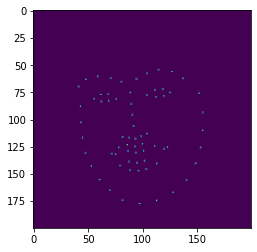

In [29]:
plt.imshow(mes.toImage(200)[7][0].detach().cpu().numpy())

/home/ibespalov/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0 0.03371685743331909


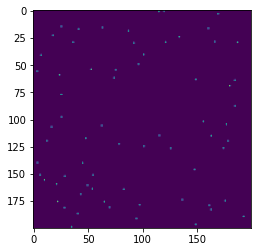

100 0.021259386092424393


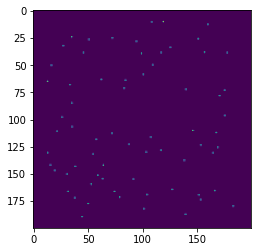

200 0.013542300090193748


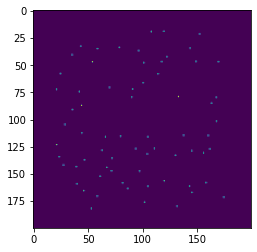

300 0.008937773294746876


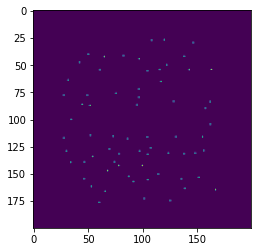

400 0.0063137030228972435


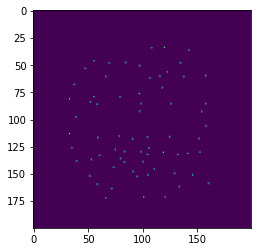

500 0.004868887830525637


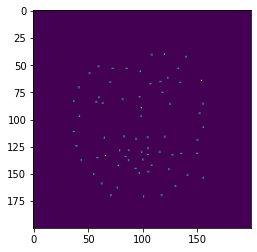

600 0.00410290015861392


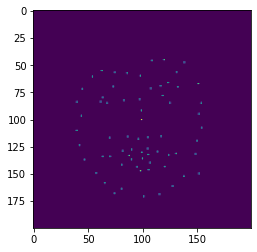

700 0.003709317883476615


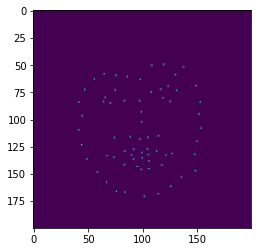

800 0.0035126942675560713


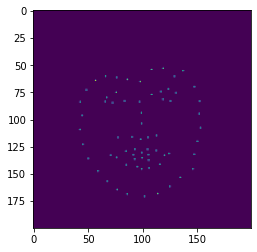

900 0.003415430895984173


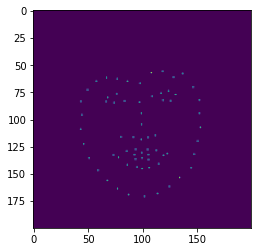

1000 0.003366750432178378


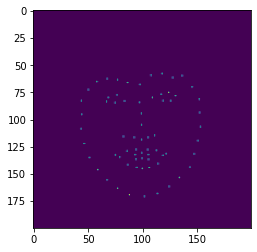

1100 0.003341417759656906


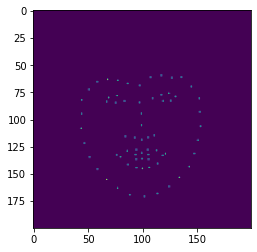

1200 0.0033275114838033915


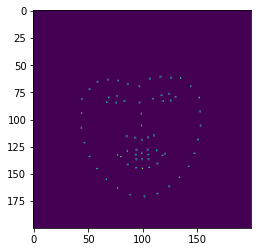

1300 0.003318998496979475


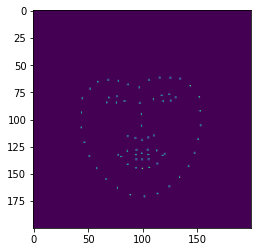

1400 0.003312204033136368


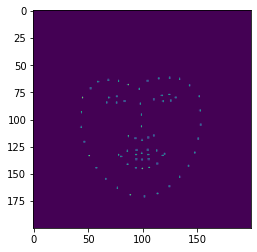

1500 0.003304598852992058


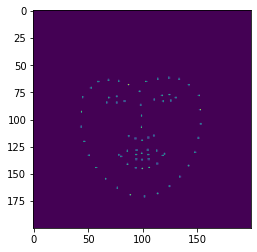

1600 0.0032953566405922174


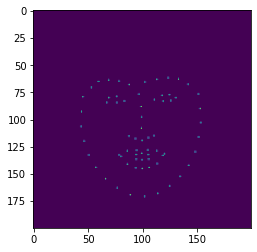

1700 0.0032885887194424868


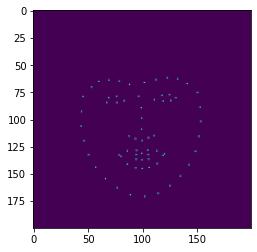

1800 0.0032852869480848312


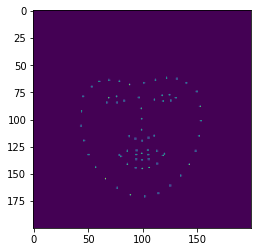

1900 0.003283645724877715


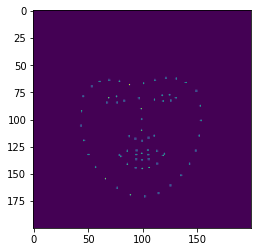

2000 0.0032827090471982956


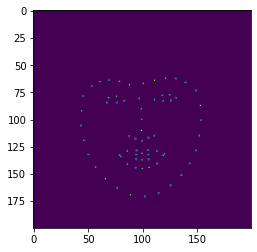

2100 0.00328214094042778


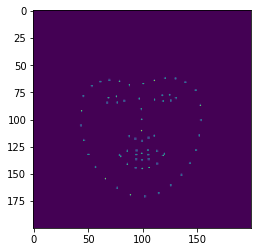

2200 0.0032817733008414507


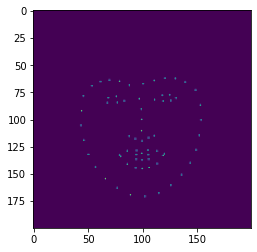

2300 0.0032814848236739635


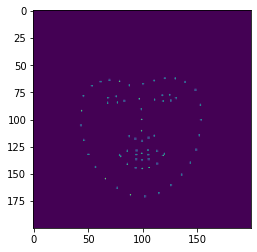

2400 0.0032811760902404785


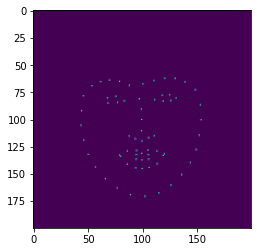

2500 0.003280789125710726


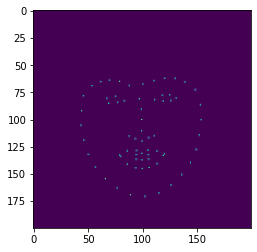

2600 0.0032803851645439863


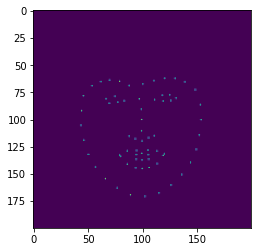

2700 0.003280131844803691


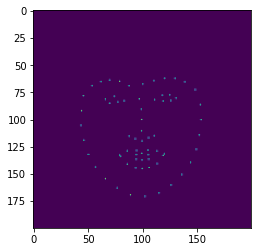

2800 0.0032799886539578438


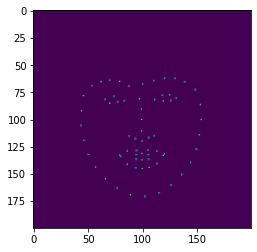

2900 0.003279853379353881


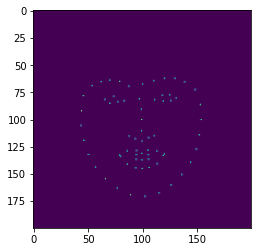

In [263]:
image_size = 256
batch_size = 100
padding = 68

fabric = ProbabilityMeasureFabric(image_size)
barycenter: ProbabilityMeasure = fabric.random(padding).cuda()
barycenter.requires_grad_()

coord = barycenter.coord

opt = optim.Adam(iter([coord]), lr=0.0005)


for i in tqdm(range(3000)):
    
#     img_coord = next(LazyLoader.w300().loader_train_inf)['meta']['keypts_normalized'].cuda()
#     mes = UniformMeasure2D01(img_coord)

    barycenter_cat = fabric.cat([barycenter] * batch_size)
    
#     loss = handmadeL1(barycenter_cat, mes).mean()
    loss = Samples_Loss(.01, .95, p=2).forward(barycenter_cat, mes).to_tensor().mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    barycenter.probability.data = barycenter.probability.relu().data
    barycenter.probability.data /= barycenter.probability.sum(dim=1, keepdim=True)
    

    if i % 100 == 0:
        print(i, loss.item())
        plt.imshow(barycenter.toImage(200)[0][0].detach().cpu().numpy())
        plt.show()

In [ ]:
barycenter10 = barycenter

In [264]:
barycenter100 = barycenter

In [259]:
barycenter70 = barycenter

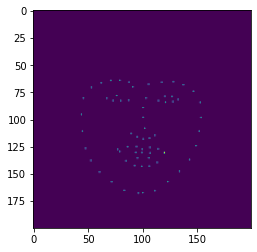

In [14]:
plt.imshow(barycenter10.toImage(200)[0][0].detach().cpu().numpy())

In [17]:
barycenter20 = barycenter

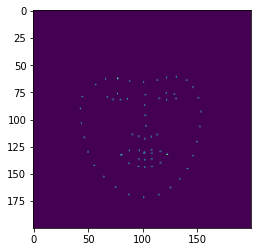

In [18]:
plt.imshow(barycenter20.toImage(200)[0][0].detach().cpu().numpy())

In [43]:
barycenter20.coord[0].detach().cpu().numpy().shape

(68, 2)

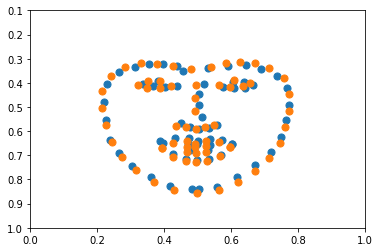

In [229]:
plt.scatter(barycenter10.coord[0].detach().cpu().numpy()[:,0], barycenter10.coord[0].detach().cpu().numpy()[:,1], s=50, alpha=1)
# plt.scatter(barycenter50.coord[0].detach().cpu().numpy()[:,0], barycenter50.coord[0].detach().cpu().numpy()[:,1], s=100, alpha=1)
# plt.scatter(barycenter20.coord[0].detach().cpu().numpy()[:,0], barycenter20.coord[0].detach().cpu().numpy()[:,1])
# plt.scatter(barycenter30.coord[0].detach().cpu().numpy()[:,0], barycenter30.coord[0].detach().cpu().numpy()[:,1], s=100, alpha=1)
# plt.scatter(barycenter50.coord[0].detach().cpu().numpy()[:,0], barycenter50.coord[0].detach().cpu().numpy()[:,1], s=100, alpha=1)
plt.scatter(barycenterall.coord[0].detach().cpu().numpy()[:,0], barycenterall.coord[0].detach().cpu().numpy()[:,1], s=50, alpha=1)
plt.xlim(0, 1)
plt.ylim(0.1, 1)
plt.gca().invert_yaxis()
plt.show()

In [236]:
list_of_w1 = []

In [261]:
list_of_w1.append(handmadew1(barycenter70, barycenterall).item())# / 0.3413

In [267]:
handmadew1(barycenter100, barycenterall).item()

0.0064346627332270145

In [254]:
list_of_w1[2] = 0.008112735076993704

In [266]:
list_of_w1[-1]

0.005312071647495031

In [279]:
list_of_w1[-1] = 0.0051176627332270145

In [203]:
barycenter30 = barycenter

In [214]:
barycenter40 = barycenter

In [223]:
barycenter5 = barycenter

In [143]:
barycenter50_5L1 = barycenter

In [10]:
barycenterall = barycenter

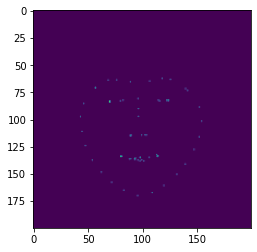

In [131]:
plt.imshow(barycenter50_3.toImage(200)[0][0].detach().cpu().numpy())

In [359]:
print(list_of_w1)

[0.013043734520673754, 0.010475884795188906, 0.009112735076993703, 0.00770652387291193, 0.006524555320336759, 0.006224555320336759, 0.005312071647495031, 0.005117662733227014]


In [4]:
list_of_w1 = [0.013043734520673754, 0.010475884795188906, 0.009112735076993703, 0.00770652387291193, 0.006524555320336759, 0.006224555320336759, 0.005312071647495031, 0.005117662733227014]

In [5]:
list_of_w1 = [i * 100 for i in list_of_w1]
print(list_of_w1)

[1.3043734520673753, 1.0475884795188906, 0.9112735076993703, 0.770652387291193, 0.6524555320336759, 0.622455532033676, 0.5312071647495031, 0.5117662733227014]


In [293]:
list_of_w1[4] = 0.007139480798691511

In [315]:
0.04 / np.sqrt(50)

0.00565685424949238

In [317]:
list_of_w1[4] = 0.006524555320336759
list_of_w1[5] = 0.006224555320336759

In [325]:
list_of_w1[0] += 0.002
list_of_w1[1] += 0.001
# list_of_w1[2] += 0.001

In [6]:
ci = [0.12] * 2 + [0.09] * 2 + [0.067] + [0.052] + [0.037] + [0.031]
ci

[0.12, 0.12, 0.09, 0.09, 0.067, 0.052, 0.037, 0.031]

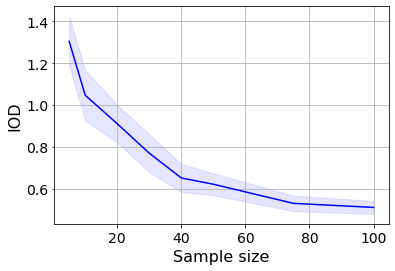

In [7]:
fig = plt.figure(1)

plot = fig.add_subplot(111)
# fig, ax = plt.subplots(111)
# ax.plot([5,10,20,30,40,50, 75, 100], list_of_w1, color='blue')
# ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.plot([5,10,20,30,40,50, 75, 100], list_of_w1, color='blue')#, label='HG2 + BRULE reg.')
# plt.plot(first_csv_step_array, smotDeriv_second * 100, color='orange', label='supervised HG2')
# ci = 0.0003
plt.fill_between([5,10,20,30,40,50, 75, 100], np.array(list_of_w1)-ci, np.array(list_of_w1)+ci, color='b', alpha=.1)

plot.tick_params(axis='x', labelsize=14, color="black")
plot.tick_params(axis='y', labelsize=14, color="black", length = 2)

plt.grid()
# plot.legend(loc=3, prop={'size': 12})
plt.xlabel('Sample size', color='black', size=16) 
# # naming the y axis 
plt.ylabel('IOD', color='black', size=16) 
plt.show()
fig.savefig("supervised_test.pdf", bbox_inches='tight')

In [244]:
!ls

barycenter_iod_value.ipynb	 munit_face_reg_true_mask.py
barycenter_MAFL.ipynb		 otrisovka.ipynb
barycenter_mafl.py		 __pycache__
barycenter.py			 stylegan_train.py
barycenters_draw.ipynb		 stylegan_train_unsupervised2.py
bez_ifovii_notebook.ipynb	 stylegan_train_unsupervised_bk.py
change_params.py		 stylegan_train_unsupervised.py
cyclegan_celeba.py		 supervised_test.pdf
data.ipynb			 test.jpg
dataparallel_module_check.ipynb  test.py
evalmodel.py			 test_transformed.jpg
face_segmentation.py		 unsupervised_otrisovka.ipynb
face_segm_regulazier_test.py	 Untitled.ipynb
face_segm_without_cond.py	 Untitleed.ipynb
gan_g_verka.py			 w300.ipynb
init_con_style.py		 w300_kp.py
__init__.py			 w300.py
landmarks_gan.py		 w300_stylegan_encoder.py
munit_face_reg.py		 w300_stylegan.py
